# Homework 1

## FINM 35700 - Spring 2025

### UChicago Financial Mathematics

* Alex Popovici
* alex.popovici@uchicago.edu

This homework relies on:

- the government and corporate bonds symbology file `bond_symbology`, 
- the "on-the-run" treasuries data file `govt_on_the_run` and
- the market data file `market_prices_eod`.


You can find more details on US treasury instruments in the FINM 37400 Fixed Income course.



In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d

import warnings
warnings.filterwarnings('ignore')

------------------------------------------------------------------------------------------
# Problem 1: Explore symbology for US treasury bonds

## a. Load and explore US government bond symbology

Load the `bond_symbology` Excel file into a dataframe. It contains symbology for both government and corporate bonds as of 2024-12-13.

Select US Treasury bonds only (class = 'Govt', ticker = 'T'). For each government bond issue, calculate its initial `term` in years (based on issue date and maturity date), as well as the current `TTM` (time-to-maturity) and extend the dataframe. Assume a year has 365.25 days.



In [2]:
bond_symbology = pd.read_excel("data/bond_symbology.xlsx")
bond_symbology['start_date'] = pd.to_datetime(bond_symbology['start_date'])
bond_symbology['cpn_first'] = pd.to_datetime(bond_symbology['cpn_first'])
bond_symbology['acc_first'] = pd.to_datetime(bond_symbology['acc_first'])
bond_symbology['maturity']   = pd.to_datetime(bond_symbology['maturity'])
display(bond_symbology.head())

,ticker,class,figi,isin,und_bench_isin,security,name,type,coupon,cpn_type,...,start_date,cpn_first,acc_first,maturity,mty_typ,rank,amt_out,country,currency,status
0,AAPL,Corp,BBG004HST0K7,US037833AL42,US912810UF39,AAPL 3.85 05/04/43,APPLE INC,GLOBAL,3.850,FIXED,...,2013-05-03,2013-11-04,2013-05-03,2043-05-04,AT MATURITY,Sr Unsecured,3000.0,US,USD,ACTV
1,AAPL,Corp,BBG006F8VWJ7,US037833AT77,US912810UF39,AAPL 4.45 05/06/44,APPLE INC,GLOBAL,4.450,FIXED,...,2014-05-06,2014-11-06,2014-05-06,2044-05-06,AT MATURITY,Sr Unsecured,1000.0,US,USD,ACTV
2,AAPL,Corp,BBG0081TNL50,US037833BA77,US912810UF39,AAPL 3.45 02/09/45,APPLE INC,GLOBAL,3.450,FIXED,...,2015-02-09,2015-08-09,2015-02-09,2045-02-09,AT MATURITY,Sr Unsecured,2000.0,US,USD,ACTV
3,AAPL,Corp,BBG008N1BQC1,US037833BH21,US912810UF39,AAPL 4 3/8 05/13/45,APPLE INC,GLOBAL,4.375,FIXED,...,2015-05-13,2015-11-13,2015-05-13,2045-05-13,AT MATURITY,Sr Unsecured,2000.0,US,USD,ACTV
4,AAPL,Corp,BBG00C7QB7Q2,US037833BY53,US91282CLY56,AAPL 3 1/4 02/23/26,APPLE INC,GLOBAL,3.250,FIXED,...,2016-02-23,2016-08-23,2016-02-23,2026-02-23,CALLABLE,Sr Unsecured,3250.0,US,USD,ACTV


In [3]:
today = pd.to_datetime("2024-12-23") # datetime.datetime.now() # Check. 
days_per_year = 365.25

bond_symbology['term'] = ((bond_symbology['maturity'] - bond_symbology['start_date']).dt.days / days_per_year)
bond_symbology['TTM'] = ((bond_symbology['maturity'] - today).dt.days / days_per_year)
bond_symbology['TTM'] = bond_symbology['TTM'].apply(lambda x: x if x > 0 else 0)

In [4]:
US_treasury_bonds = bond_symbology[(bond_symbology["class"] == "Govt") & (bond_symbology["ticker"] == "T")]
display(US_treasury_bonds.tail())

,ticker,class,figi,isin,und_bench_isin,security,name,type,coupon,cpn_type,...,acc_first,maturity,mty_typ,rank,amt_out,country,currency,status,term,TTM
715,T,Govt,BBG01QZFYJV6,US91282CLY56,US91282CLY56,T 4 1/4 11/30/26,US TREASURY N/B,US GOVERNMENT,4.250,FIXED,...,2024-11-30,2026-11-30,NORMAL,Unsecured,73693.0,US,USD,ACTV,1.993155,1.935661
716,T,Govt,BBG01QZFYD58,US91282CMA61,US91282CMA61,T 4 1/8 11/30/29,US TREASURY N/B,US GOVERNMENT,4.125,FIXED,...,2024-11-30,2029-11-30,NORMAL,Unsecured,74761.0,US,USD,ACTV,4.993840,4.936345
717,T,Govt,BBG01QZFYCF9,US91282CLZ22,US91282CLZ22,T 4 1/8 11/30/31,US TREASURY N/B,US GOVERNMENT,4.125,FIXED,...,2024-11-30,2031-11-30,NORMAL,Unsecured,46993.0,US,USD,ACTV,6.992471,6.934976
718,T,Govt,BBG01QVTC1Y0,US912810UF39,US912810UF39,T 4 5/8 11/15/44,US TREASURY N/B,US GOVERNMENT,4.625,FIXED,...,2024-11-15,2044-11-15,NORMAL,Unsecured,17088.0,US,USD,ACTV,19.953457,19.895962
719,T,Govt,BBG01R4Z7Y32,US91282CMB45,US91282CMB45,T 4 12/15/27,US TREASURY N/B,US GOVERNMENT,4.000,FIXED,...,2024-12-15,2027-12-15,NORMAL,Unsecured,58415.0,US,USD,ACTV,2.995209,2.976044


## b. Historical time series of US treasury coupons 

Plot the time series of coupons for for US treasury notes/bonds issued since 2015 (indexed by issue date). 
What can you say about the overall level of issued coupons since 2020?


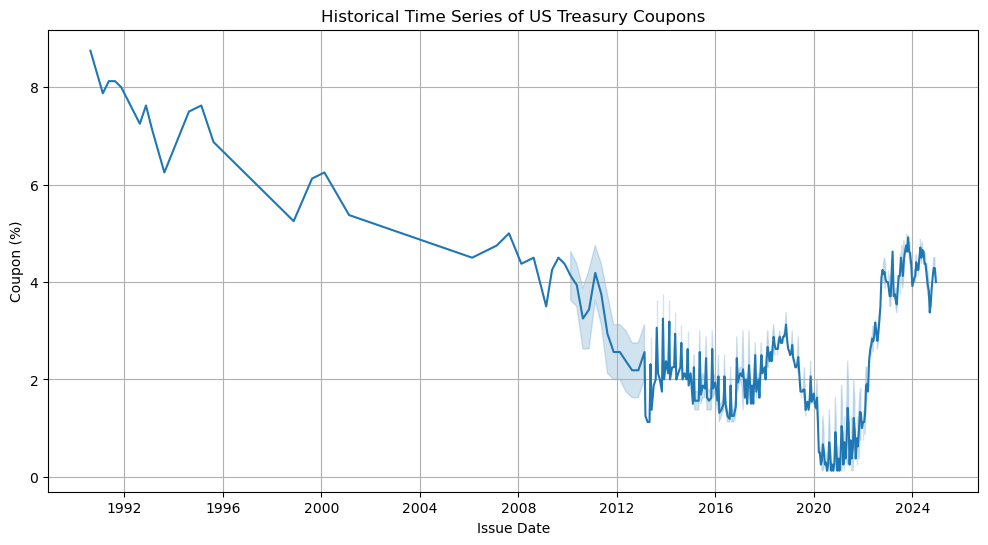

In [5]:
US_treasury_bonds = US_treasury_bonds.sort_values("start_date")

plt.figure(figsize=(12,6))
sns.lineplot(data=US_treasury_bonds,x="start_date",y="coupon")
plt.title("Historical Time Series of US Treasury Coupons")
plt.xlabel("Issue Date")
plt.ylabel("Coupon (%)")
plt.grid(True)
plt.show()

- Coupons between 2020 and 2022 were very low (Almost between 0.5% -1%).
- Around 2022, newly issued Treasury coupons have risen sharply from the near‐historical lows of the teh 2020's
- In early 2020, the Federal Reserve dropped rates to stimulate the economy, and new Treasury issuance has coupons around 0.5%–1.0% range for shorter maturities.
- By late 2021/ early 2022, as inflation rose and the Fed began rising interest rates.
- Coupons on newly issued Treasuries climbed back up into the 3%–4% range and beyond.
- The overall level of issued coupons post‐2020 clearly shows a turnaround from the ultra‐low rates to higher.

## c. Load the on-the-run US treasuries

Load the `govt_on_the_run` Excel file into a dataframe. Select the current on-the-run 2Y, 3Y, 5Y, 7Y, 10Y, 20Y and 30Y issues (off-the-run issues have the B & C suffix). Create a separate symbology dataframe for on-the-run treasuries only, to be used later on for the on-the-run government yield curve bootstrapping.

In [6]:
govt_on_the_run = pd.read_excel("data/govt_on_the_run.xlsx")
on_the_run_list = ["2Y","3Y","5Y","7Y","10Y","20Y","30Y"]

pattern = r"^GT(\d+)([A-Z])?\sGovt$"
govt_on_the_run[["tenor", "suffix"]] = govt_on_the_run["ticker"].str.extract(pattern)
govt_on_the_run["tenor"] = govt_on_the_run["tenor"] + "Y"

on_the_run_bonds = govt_on_the_run[(govt_on_the_run["tenor"].isin(on_the_run_list)) & (govt_on_the_run["suffix"].isna())].copy()
us_treasuries_on_the_run = pd.merge(US_treasury_bonds, on_the_run_bonds, on=["figi", "isin"]).drop(["suffix", "ticker_y", "date", "tenor"], axis=1).rename(columns={"ticker_x": "ticker"})

print("On-the-run US Treasury bonds")
display(us_treasuries_on_the_run)

On-the-run US Treasury bonds


,ticker,class,figi,isin,und_bench_isin,security,name,type,coupon,cpn_type,...,acc_first,maturity,mty_typ,rank,amt_out,country,currency,status,term,TTM
0,T,Govt,BBG01QKHSMP5,US91282CLW90,US91282CLW90,T 4 1/4 11/15/34,US TREASURY N/B,US GOVERNMENT,4.250,FIXED,...,2024-11-15,2034-11-15,NORMAL,Unsecured,91486.0,US,USD,ACTV,9.998631,9.894593
1,T,Govt,BBG01QKHSL31,US912810UE63,US912810UE63,T 4 1/2 11/15/54,US TREASURY N/B,US GOVERNMENT,4.500,FIXED,...,2024-11-15,2054-11-15,NORMAL,Unsecured,53231.0,US,USD,ACTV,29.998631,29.894593
2,T,Govt,BBG01QVTC1Y0,US912810UF39,US912810UF39,T 4 5/8 11/15/44,US TREASURY N/B,US GOVERNMENT,4.625,FIXED,...,2024-11-15,2044-11-15,NORMAL,Unsecured,17088.0,US,USD,ACTV,19.953457,19.895962
3,T,Govt,BBG01QZFYJV6,US91282CLY56,US91282CLY56,T 4 1/4 11/30/26,US TREASURY N/B,US GOVERNMENT,4.250,FIXED,...,2024-11-30,2026-11-30,NORMAL,Unsecured,73693.0,US,USD,ACTV,1.993155,1.935661
4,T,Govt,BBG01QZFYD58,US91282CMA61,US91282CMA61,T 4 1/8 11/30/29,US TREASURY N/B,US GOVERNMENT,4.125,FIXED,...,2024-11-30,2029-11-30,NORMAL,Unsecured,74761.0,US,USD,ACTV,4.993840,4.936345
5,T,Govt,BBG01QZFYCF9,US91282CLZ22,US91282CLZ22,T 4 1/8 11/30/31,US TREASURY N/B,US GOVERNMENT,4.125,FIXED,...,2024-11-30,2031-11-30,NORMAL,Unsecured,46993.0,US,USD,ACTV,6.992471,6.934976
6,T,Govt,BBG01R4Z7Y32,US91282CMB45,US91282CMB45,T 4 12/15/27,US TREASURY N/B,US GOVERNMENT,4.000,FIXED,...,2024-12-15,2027-12-15,NORMAL,Unsecured,58415.0,US,USD,ACTV,2.995209,2.976044


## d. Compute the total amount of US Treasuries issued / matured every year since 2015

Column `amt_out` contains the issue amount outstanding, expressed in $MM.

Compute the total amount of US Treasuries issued every year since 2015.
Compute the total amount of US Treasuries matured every year since 2015.

Plot the results.

In [7]:
US_treasury_bonds['issue_year'] = US_treasury_bonds['start_date'].dt.year
US_treasury_bonds['maturity_year'] = US_treasury_bonds['maturity'].dt.year

issued_by_year = US_treasury_bonds.groupby('issue_year')['amt_out'].sum().reset_index().rename(columns={'issue_year': 'year', 'amt_out': 'total_issued'})
matured_by_year = US_treasury_bonds.groupby('maturity_year')['amt_out'].sum().reset_index().rename(columns={'maturity_year': 'year', 'amt_out': 'total_matured'})

In [8]:
issued_by_year = issued_by_year[issued_by_year['year'] >= 2015]
matured_by_year = matured_by_year[matured_by_year['year'] >= 2015]

print("Total Issued by Year (>= 2015)")
display(issued_by_year)

print("Total Matured by Year (>= 2015)")
display(matured_by_year)

Total Issued by Year (>= 2015)


,year,total_issued
19,2015,988924.0
20,2016,1217460.0
21,2017,1330458.0
22,2018,1940847.0
23,2019,2322466.0
24,2020,3558513.0
25,2021,4601404.0
26,2022,3251806.0
27,2023,3028042.0
28,2024,3827422.0


Total Matured by Year (>= 2015)


,year,total_matured
0,2020,609714.0
1,2021,2068029.0
2,2022,2249135.0
3,2023,2631092.0
4,2024,2629231.0
5,2025,2546043.0
6,2026,2820514.0
7,2027,2209885.0
8,2028,1740371.0
9,2029,1678745.0


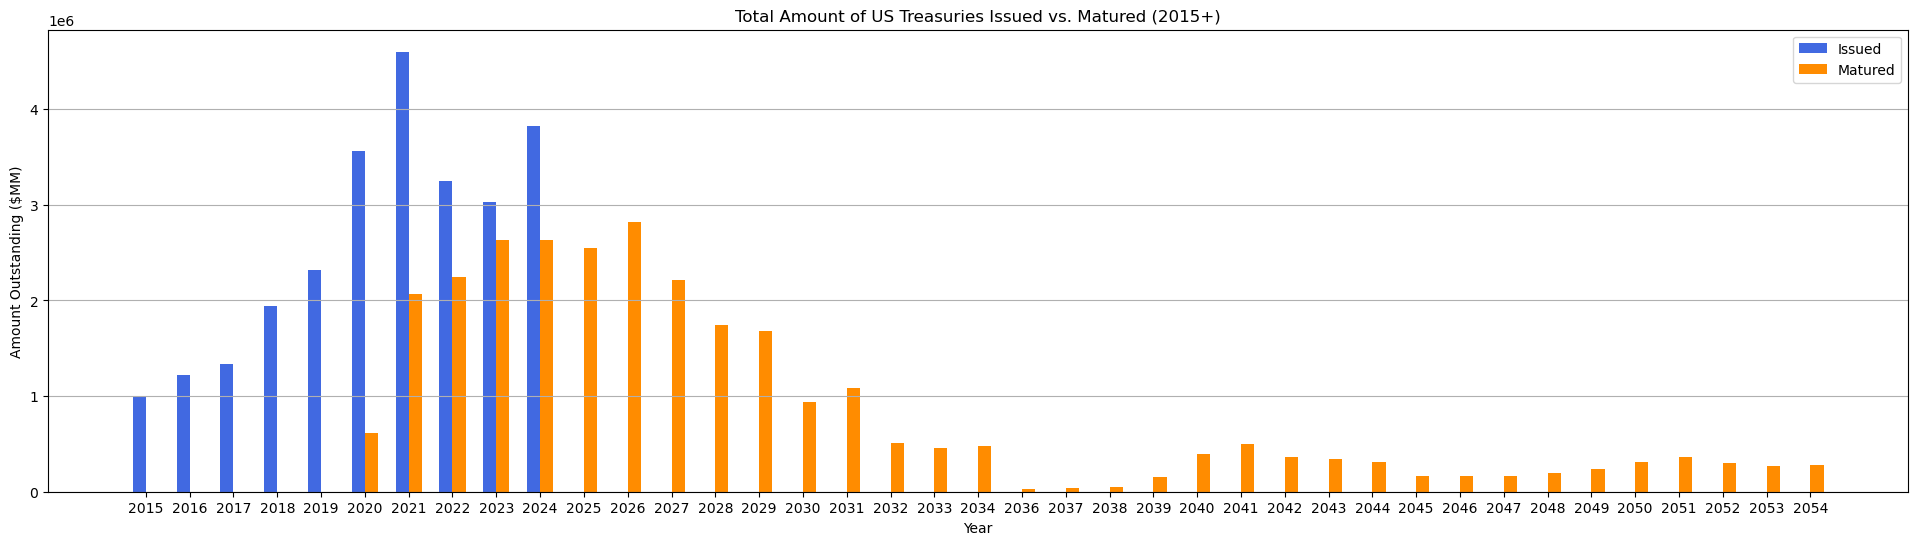

In [9]:
yearly_data = pd.merge(issued_by_year,matured_by_year,on='year',how='outer').fillna(0)  

plt.figure(figsize=(24,6))
bar_width = 0.3
x_positions = np.arange(len(yearly_data['year']))
plt.bar(x_positions - bar_width/2, yearly_data['total_issued'], width=bar_width, label='Issued', color='royalblue')
plt.bar(x_positions + bar_width/2, yearly_data['total_matured'], width=bar_width, label='Matured', color='darkorange')
plt.xticks(x_positions, yearly_data['year'], rotation=0)
plt.xlabel("Year")
plt.ylabel("Amount Outstanding ($MM)")
plt.title("Total Amount of US Treasuries Issued vs. Matured (2015+)")
plt.legend()
plt.grid(True, axis='y')
plt.show()

------------------------------------------------------------------------------------------
# Problem 2: Explore symbology for corporate bonds

## a. Load and explore US corporate bonds symbology data

Starting from the `bond_symbology` dataframe, create a corporate bond dataframe containing
* corporate bond only  (class = "Corp"),
* senior unsecured (rank = "Sr Unsecured"),
* fixed coupon (cpn_type="FIXED")
* maturity date <= 2055-12-31

bonds only, with following columns:



| ticker | isin | figi | security | name | coupon | start_date | maturity | amt_out | term | TTM |
|----------|-------|-------|-------------|-----|----------|---------|---------|---------|---------|---------|

where 
* `term` refers to the initial term/time-to-maturity in years
* `TTM` refers to the current time-to-maturity in years

Display the dataframe.

In [10]:
corporate_bonds = bond_symbology[(bond_symbology["class"] == "Corp") & (bond_symbology["rank"] == "Sr Unsecured") & (bond_symbology["cpn_type"] == "FIXED") & (bond_symbology["maturity"] <= "2055-12-31")].copy()
display(corporate_bonds.head())

,ticker,class,figi,isin,und_bench_isin,security,name,type,coupon,cpn_type,...,acc_first,maturity,mty_typ,rank,amt_out,country,currency,status,term,TTM
0,AAPL,Corp,BBG004HST0K7,US037833AL42,US912810UF39,AAPL 3.85 05/04/43,APPLE INC,GLOBAL,3.850,FIXED,...,2013-05-03,2043-05-04,AT MATURITY,Sr Unsecured,3000.0,US,USD,ACTV,30.001369,18.360027
1,AAPL,Corp,BBG006F8VWJ7,US037833AT77,US912810UF39,AAPL 4.45 05/06/44,APPLE INC,GLOBAL,4.450,FIXED,...,2014-05-06,2044-05-06,AT MATURITY,Sr Unsecured,1000.0,US,USD,ACTV,30.001369,19.367556
2,AAPL,Corp,BBG0081TNL50,US037833BA77,US912810UF39,AAPL 3.45 02/09/45,APPLE INC,GLOBAL,3.450,FIXED,...,2015-02-09,2045-02-09,AT MATURITY,Sr Unsecured,2000.0,US,USD,ACTV,30.001369,20.131417
3,AAPL,Corp,BBG008N1BQC1,US037833BH21,US912810UF39,AAPL 4 3/8 05/13/45,APPLE INC,GLOBAL,4.375,FIXED,...,2015-05-13,2045-05-13,AT MATURITY,Sr Unsecured,2000.0,US,USD,ACTV,30.001369,20.386037
4,AAPL,Corp,BBG00C7QB7Q2,US037833BY53,US91282CLY56,AAPL 3 1/4 02/23/26,APPLE INC,GLOBAL,3.250,FIXED,...,2016-02-23,2026-02-23,CALLABLE,Sr Unsecured,3250.0,US,USD,ACTV,10.001369,1.169062


## b. Explore aggregated issue amount outstanding by issuer

Compute the total issue (face) amount outstanding for each issuer and display the results.

In [11]:
issuer_amt = corporate_bonds.groupby("name", as_index=False)["amt_out"].sum()
display(issuer_amt)

,name,amt_out
0,APPLE INC,71100.000
1,IBM CORP,28284.172
2,ORACLE CORP,69240.435
3,WALT DISNEY COMPANY/THE,25062.036


## c. Display the bond details for Disney

Create a separate dataframe for Disney issuer only (ticker = 'DIS') and display it.

Compute following aggregated metrics for DIS:
* average coupon
* average term and
* average TTM.

In [12]:
df_dis = corporate_bonds[corporate_bonds["ticker"] == "DIS"].copy()
display(df_dis.head())

,ticker,class,figi,isin,und_bench_isin,security,name,type,coupon,cpn_type,...,acc_first,maturity,mty_typ,rank,amt_out,country,currency,status,term,TTM
43,DIS,Corp,BBG00N3BD9G0,USU25497AR66,US91282CMA61,DIS 7 1/8 04/08/28,WALT DISNEY COMPANY/THE,EURO-DOLLAR,7.125,FIXED,...,2019-03-20,2028-04-08,AT MATURITY,Sr Unsecured,10.285,US,USD,ACTV,9.054073,3.290897
44,DIS,Corp,BBG00N3BZ921,USU25497AW51,US91282CLW90,DIS 8.45 08/01/34,WALT DISNEY COMPANY/THE,EURO-DOLLAR,8.450,FIXED,...,2019-03-20,2034-08-01,AT MATURITY,Sr Unsecured,1.000,US,USD,ACTV,15.367556,9.604381
47,DIS,Corp,BBG00Q5D3237,US254687FL52,US91282CMA61,DIS 2 09/01/29,WALT DISNEY COMPANY/THE,GLOBAL,2.000,FIXED,...,2019-09-06,2029-09-01,CALLABLE,Sr Unsecured,2000.000,US,USD,ACTV,9.987680,4.689938
48,DIS,Corp,BBG00Q5D3246,US254687FM36,US912810UC08,DIS 2 3/4 09/01/49,WALT DISNEY COMPANY/THE,GLOBAL,2.750,FIXED,...,2019-09-06,2049-09-01,CALLABLE,Sr Unsecured,2000.000,US,USD,ACTV,29.987680,24.689938
49,DIS,Corp,BBG00QNKGJP6,US254687DK97,US91282CLY56,DIS 3 3/8 11/15/26,WALT DISNEY COMPANY/THE,GLOBAL,3.375,FIXED,...,2019-11-15,2026-11-15,CALLABLE,Sr Unsecured,436.285,US,USD,ACTV,6.981520,1.894593


In [13]:
avg_coupon = df_dis["coupon"].mean()
avg_term = df_dis["term"].mean()
avg_ttm = df_dis["TTM"].mean()
print(f"DIS average coupon: {avg_coupon:.2f}")
print(f"DIS average term: {avg_term:.2f}")
print(f"DIS average TTM: {avg_ttm:.2f}")

DIS average coupon: 4.80
DIS average term: 17.66
DIS average TTM: 12.65


## d. Explore term structure of issue amounts outstanding for Disney.

Plot the issue amount outstanding by TTM for Disney.

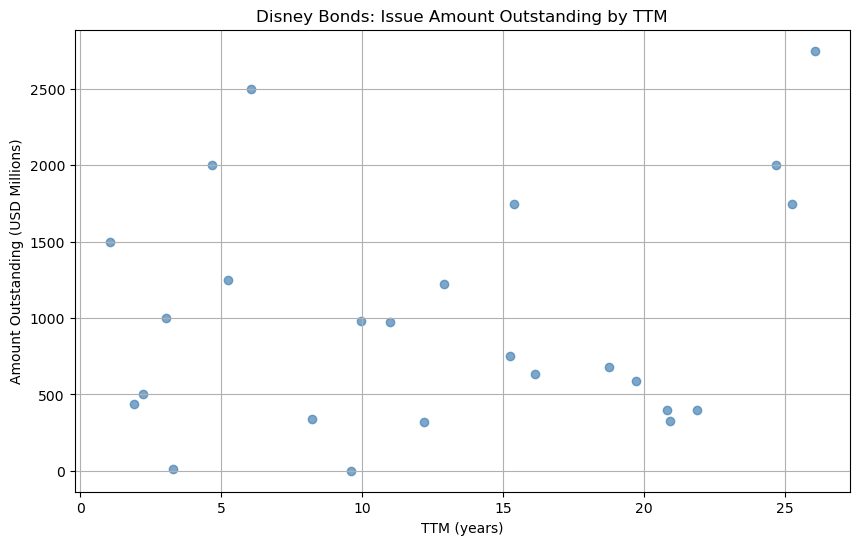

In [14]:
plt.figure(figsize=(10,6))
plt.scatter(df_dis["TTM"], df_dis["amt_out"], color="steelblue", alpha=0.7)
plt.title("Disney Bonds: Issue Amount Outstanding by TTM")
plt.xlabel("TTM (years)")
plt.ylabel("Amount Outstanding (USD Millions)")
plt.grid(True)
plt.show()

------------------------------------------------------------------------------------------
# Problem 3: Explore EOD market prices and yields

## a. Load and explore treasury market prices and yields

Load the `bond_market_prices_eod` Excel file into a dataframe. It provides market data for US treasuries and corporate bonds as of 2024-12-13.

Merge the treasuries symbology dataframe with the market data and add the following columns:


| date | bidPrice | askPrice | midPrice | bidYield | askYield | midYield | term | TTM |
|----------|-------|-------------|-----|----------|---------|---------|---------|---------|

Plot a graph/scatter plot of treasury mid yields by TTM.


In [15]:
bond_market_prices_eod = pd.read_excel("data/bond_market_prices_eod.xlsx")
bond_market_prices_eod["date"] = pd.to_datetime(bond_market_prices_eod["date"])
display(bond_market_prices_eod.head())

,date,class,ticker,isin,figi,bidPrice,askPrice,accrued,bidYield,askYield
0,2024-12-13,Corp,AAPL,US037833BX70,BBG00C7QBG91,93.228,93.809,1.4595,5.180,5.132
1,2024-12-13,Corp,AAPL,US037833EK23,BBG011ZS1X57,63.723,64.232,0.9835,5.242,5.194
2,2024-12-13,Corp,AAPL,US037833DW79,BBG00TN2PN26,63.716,64.215,0.2585,5.253,5.205
3,2024-12-13,Corp,AAPL,US037833EF38,BBG00Z3VQ626,63.262,63.766,0.9420,5.249,5.200
4,2024-12-13,Corp,AAPL,US037833CD08,BBG00DHQX9M5,82.278,82.848,1.4120,5.227,5.177


In [16]:
merged_treasuries = pd.merge(US_treasury_bonds,
    bond_market_prices_eod,
    on=["ticker","isin","figi"],
    how="inner"
)
merged_treasuries = merged_treasuries.drop(columns=["class_y", "issue_year", "maturity_year", "accrued"])
merged_treasuries.rename(columns={"class_x": "class"}, inplace=True)
merged_treasuries["midPrice"] = (merged_treasuries["bidPrice"] + merged_treasuries["askPrice"])/2
merged_treasuries["midYield"] = (merged_treasuries["bidYield"] + merged_treasuries["askYield"])/2
merged_treasuries.head()

,ticker,class,figi,isin,und_bench_isin,security,name,type,coupon,cpn_type,...,status,term,TTM,date,bidPrice,askPrice,bidYield,askYield,midPrice,midYield
0,T,Govt,BBG000FJ0QD9,US912810FF04,US91282CMB45,T 5 1/4 11/15/28,US TREASURY N/B,US GOVERNMENT,5.250,FIXED,...,ACTV,29.998631,3.895962,2024-12-13,103.4141,103.8828,4.292,4.164,103.64845,4.2280
1,T,Govt,BBG000FVQ8V4,US912810FJ26,US91282CMA61,T 6 1/8 08/15/29,US TREASURY N/B,US GOVERNMENT,6.125,FIXED,...,ACTV,29.998631,4.643395,2024-12-13,107.6328,108.1172,4.300,4.190,107.87500,4.2450
2,T,Govt,BBG000FYM9P7,US912810FM54,US91282CMA61,T 6 1/4 05/15/30,US TREASURY N/B,US GOVERNMENT,6.250,FIXED,...,ACTV,30.245038,5.390828,2024-12-13,109.2188,109.6484,4.321,4.236,109.43360,4.2785
3,T,Govt,BBG000FZB1J0,US912810FP85,US91282CMA61,T 5 3/8 02/15/31,US TREASURY N/B,US GOVERNMENT,5.375,FIXED,...,ACTV,29.998631,6.146475,2024-12-13,105.7500,106.1563,4.302,4.229,105.95315,4.2655
4,T,Govt,BBG000FLF6H8,US912810FT08,US91282CLW90,T 4 1/2 02/15/36,US TREASURY N/B,US GOVERNMENT,4.500,FIXED,...,ACTV,29.998631,11.145791,2024-12-13,101.4375,101.7031,4.336,4.306,101.57030,4.3210


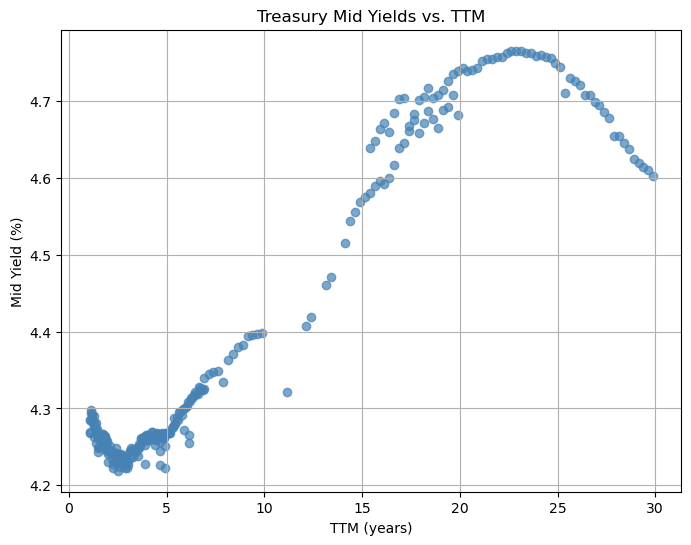

In [17]:
merged_treasuries["midYield"] = (merged_treasuries["bidYield"] + merged_treasuries["askYield"])/2
df_treas = merged_treasuries.dropna(subset=["midYield","TTM"])
plt.figure(figsize=(8,6))
plt.scatter(df_treas["TTM"], df_treas["midYield"], color="steelblue", alpha=0.7)
plt.xlabel("TTM (years)")
plt.ylabel("Mid Yield (%)")
plt.title("Treasury Mid Yields vs. TTM")
plt.grid(True)
plt.show()

## b. Explore on-the-run treasuries only
Create a separate joint dataframe for on-the-run treasuries only.

Plot a graph/scatter plot of on-the-run treasury mid yields by TTM.

In [18]:
merge_columns = list(set(merged_treasuries.columns).intersection(set(us_treasuries_on_the_run)))
merged_us_treasuries_on_the_run = pd.merge(merged_treasuries, us_treasuries_on_the_run, on=merge_columns, how="inner")
merged_us_treasuries_on_the_run.head()

,ticker,class,figi,isin,und_bench_isin,security,name,type,coupon,cpn_type,...,status,term,TTM,date,bidPrice,askPrice,bidYield,askYield,midPrice,midYield
0,T,Govt,BBG01QKHSMP5,US91282CLW90,US91282CLW90,T 4 1/4 11/15/34,US TREASURY N/B,US GOVERNMENT,4.250,FIXED,...,ACTV,9.998631,9.894593,2024-12-13,98.8125,98.8281,4.399,4.397,98.82030,4.398
1,T,Govt,BBG01QKHSL31,US912810UE63,US912810UE63,T 4 1/2 11/15/54,US TREASURY N/B,US GOVERNMENT,4.500,FIXED,...,ACTV,29.998631,29.894593,2024-12-13,98.3281,98.3594,4.603,4.601,98.34375,4.602
2,T,Govt,BBG01QVTC1Y0,US912810UF39,US912810UF39,T 4 5/8 11/15/44,US TREASURY N/B,US GOVERNMENT,4.625,FIXED,...,ACTV,19.953457,19.895962,2024-12-13,99.2500,99.2813,4.683,4.681,99.26565,4.682
3,T,Govt,BBG01QZFYJV6,US91282CLY56,US91282CLY56,T 4 1/4 11/30/26,US TREASURY N/B,US GOVERNMENT,4.250,FIXED,...,ACTV,1.993155,1.935661,2024-12-13,100.0000,100.0078,4.249,4.245,100.00390,4.247
4,T,Govt,BBG01QZFYD58,US91282CMA61,US91282CMA61,T 4 1/8 11/30/29,US TREASURY N/B,US GOVERNMENT,4.125,FIXED,...,ACTV,4.993840,4.936345,2024-12-13,99.4375,99.4453,4.252,4.250,99.44140,4.251


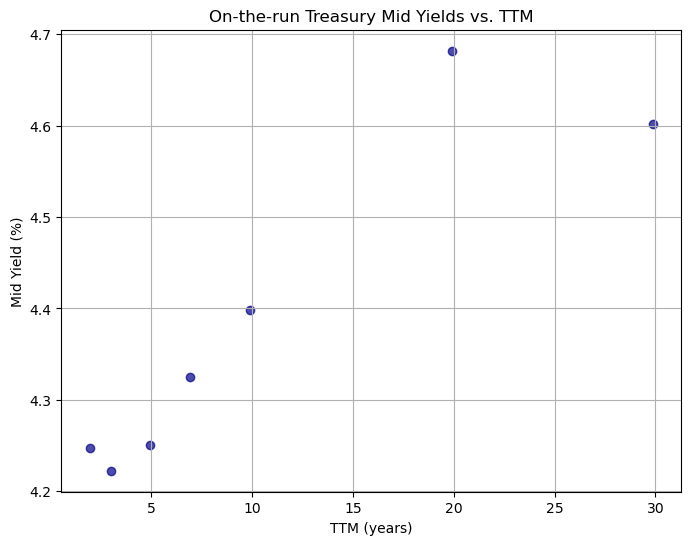

In [19]:
plt.figure(figsize=(8,6))
plt.scatter(merged_us_treasuries_on_the_run["TTM"], merged_us_treasuries_on_the_run["midYield"], color="darkblue", alpha=0.7)
plt.xlabel("TTM (years)")
plt.ylabel("Mid Yield (%)")
plt.title("On-the-run Treasury Mid Yields vs. TTM")
plt.grid(True)
plt.show()

## c. Load and explore corporate bond market prices and yields

Merge the filtered corporate bonds symbology dataframe with the market data and add the following columns:

| date | bidPrice | askPrice | midPrice | bidYield | askYield | midYield | term | TTM |
|----------|-------|-------------|-----|----------|---------|---------|---------|---------|

List the unique tickers/issuers available in the dataframe.


In [20]:
merged_corporate = pd.merge(
    corporate_bonds,
    bond_market_prices_eod,
    on=["class", "ticker","isin","figi"],
    how="inner"
)
merged_corporate["midPrice"] = (merged_corporate["bidPrice"] + merged_corporate["askPrice"])/2
merged_corporate["midYield"] = (merged_corporate["bidYield"] + merged_corporate["askYield"])/2
display(merged_corporate.head())

unique_corp_issuers = merged_corporate["ticker"].unique()
list(unique_corp_issuers)

,ticker,class,figi,isin,und_bench_isin,security,name,type,coupon,cpn_type,...,term,TTM,date,bidPrice,askPrice,accrued,bidYield,askYield,midPrice,midYield
0,AAPL,Corp,BBG004HST0K7,US037833AL42,US912810UF39,AAPL 3.85 05/04/43,APPLE INC,GLOBAL,3.850,FIXED,...,30.001369,18.360027,2024-12-13,84.586,85.148,0.4490,5.157,5.105,84.8670,5.1310
1,AAPL,Corp,BBG006F8VWJ7,US037833AT77,US912810UF39,AAPL 4.45 05/06/44,APPLE INC,GLOBAL,4.450,FIXED,...,30.001369,19.367556,2024-12-13,92.869,93.617,0.4940,5.030,4.966,93.2430,4.9980
2,AAPL,Corp,BBG0081TNL50,US037833BA77,US912810UF39,AAPL 3.45 02/09/45,APPLE INC,GLOBAL,3.450,FIXED,...,30.001369,20.131417,2024-12-13,78.309,78.915,1.2170,5.200,5.143,78.6120,5.1715
3,AAPL,Corp,BBG008N1BQC1,US037833BH21,US912810UF39,AAPL 4 3/8 05/13/45,APPLE INC,GLOBAL,4.375,FIXED,...,30.001369,20.386037,2024-12-13,89.877,90.517,0.4010,5.184,5.130,90.1970,5.1570
4,AAPL,Corp,BBG00C7QB7Q2,US037833BY53,US91282CLY56,AAPL 3 1/4 02/23/26,APPLE INC,GLOBAL,3.250,FIXED,...,10.001369,1.169062,2024-12-13,98.618,98.771,1.0205,4.455,4.321,98.6945,4.3880


['AAPL', 'DIS', 'IBM', 'ORCL']

## d. Yield curve plots

Plot a graph/scatter plot of mid yield curves by TTM (one line per ticker/issuer).

Add a separate line for on-the-run US treasury yield curve (risk free curve).

What can you say about the credit issuer yields, compared to US treasury yields?

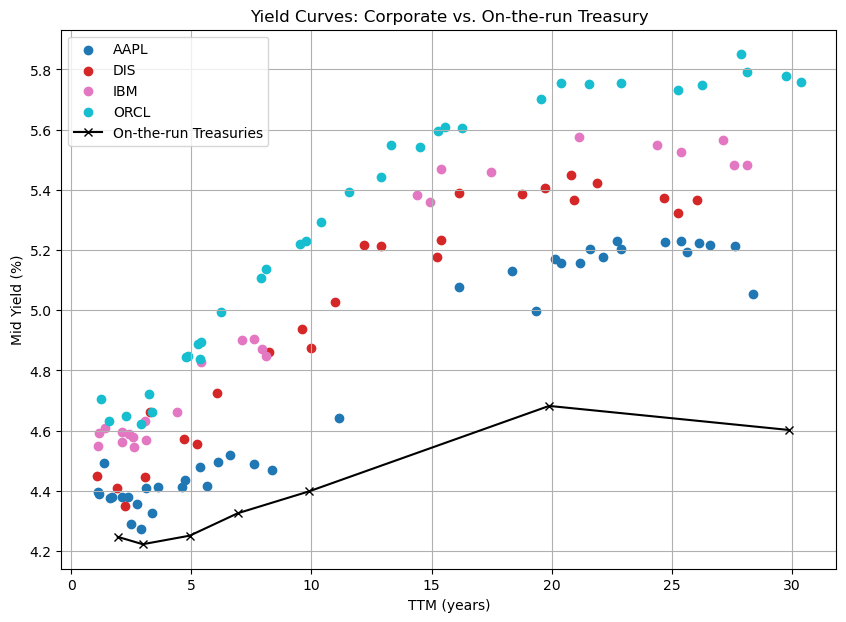

In [21]:
issuer_colors = plt.cm.get_cmap("tab10", len(unique_corp_issuers))

plt.figure(figsize=(10,7))
for i, issuer in enumerate(unique_corp_issuers):
    data_issuer = merged_corporate[merged_corporate["ticker"] == issuer].dropna(subset=["midYield","TTM"])
    plt.scatter(
        data_issuer["TTM"],
        data_issuer["midYield"],
        label=issuer,
        color=issuer_colors(i)
    )

on_run_data = merged_us_treasuries_on_the_run.dropna(subset=["midYield","TTM"])
on_run_data_sorted = on_run_data.sort_values("TTM")
plt.plot(
    on_run_data_sorted["TTM"],
    on_run_data_sorted["midYield"],
    marker="x",
    color="black",
    label="On-the-run Treasuries"
)

plt.xlabel("TTM (years)")
plt.ylabel("Mid Yield (%)")
plt.title("Yield Curves: Corporate vs. On-the-run Treasury")
plt.legend()
plt.grid(True)
plt.show()

------------------------------------------------------------------------------------------
# Problem 4: Underying treasury benchmarks and credit spreads

## a. Add underlying benchmark bond mid yields

Start with the corporate bond symbology dataframe. Use the column 'und_bench_yield' to identify the underlying benchmark bond for each bond issue.

Add two new columns to the joint corporate bond dataframe:

| und_bench_yield | credit_spread |
|----------|-------|

where 

*  `und_bench_yield` = underlying benchmark bond mid yield and
*  `credit_spread` = (issue yield - underlying benchmark bond mid yield) * 100.

In [22]:
df_corp = pd.merge(merged_corporate, merged_treasuries[["isin","midYield"]], left_on="und_bench_isin", right_on="isin", how="left")
df_corp = df_corp.rename(columns={"midYield_x": "midYield", "midYield_y": "und_bench_yield", "isin_x": "isin"}).drop(columns=["isin_y"])
df_corp["credit_spread"] = (df_corp["midYield"] - df_corp["und_bench_yield"])*100
df_corp

,ticker,class,figi,isin,und_bench_isin,security,name,type,coupon,cpn_type,...,date,bidPrice,askPrice,accrued,bidYield,askYield,midPrice,midYield,und_bench_yield,credit_spread
0,AAPL,Corp,BBG004HST0K7,US037833AL42,US912810UF39,AAPL 3.85 05/04/43,APPLE INC,GLOBAL,3.850,FIXED,...,2024-12-13,84.586,85.148,0.4490,5.157,5.105,84.8670,5.1310,4.6820,44.90
1,AAPL,Corp,BBG006F8VWJ7,US037833AT77,US912810UF39,AAPL 4.45 05/06/44,APPLE INC,GLOBAL,4.450,FIXED,...,2024-12-13,92.869,93.617,0.4940,5.030,4.966,93.2430,4.9980,4.6820,31.60
2,AAPL,Corp,BBG0081TNL50,US037833BA77,US912810UF39,AAPL 3.45 02/09/45,APPLE INC,GLOBAL,3.450,FIXED,...,2024-12-13,78.309,78.915,1.2170,5.200,5.143,78.6120,5.1715,4.6820,48.95
3,AAPL,Corp,BBG008N1BQC1,US037833BH21,US912810UF39,AAPL 4 3/8 05/13/45,APPLE INC,GLOBAL,4.375,FIXED,...,2024-12-13,89.877,90.517,0.4010,5.184,5.130,90.1970,5.1570,4.6820,47.50
4,AAPL,Corp,BBG00C7QB7Q2,US037833BY53,US91282CLY56,AAPL 3 1/4 02/23/26,APPLE INC,GLOBAL,3.250,FIXED,...,2024-12-13,98.618,98.771,1.0205,4.455,4.321,98.6945,4.3880,4.2470,14.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,ORCL,Corp,BBG01DZ9FPR1,US68389XCP87,US91282CLW90,ORCL 4.9 02/06/33,ORACLE CORP,GLOBAL,4.900,FIXED,...,2024-12-13,98.226,98.646,1.7690,5.169,5.104,98.4360,5.1365,4.3980,73.85
120,ORCL,Corp,BBG01DZ9FPY3,US68389XCQ60,US912810UC08,ORCL 5.55 02/06/53,ORACLE CORP,GLOBAL,5.550,FIXED,...,2024-12-13,96.308,96.976,2.0040,5.818,5.768,96.6420,5.7930,4.6105,118.25
121,ORCL,Corp,BBG01Q0P7VR0,US68389XCS27,US91282CMA61,ORCL 4.2 09/27/29,ORACLE CORP,GLOBAL,4.200,FIXED,...,2024-12-13,97.140,97.390,0.9220,4.876,4.816,97.2650,4.8460,4.2510,59.50
122,ORCL,Corp,BBG01Q0P7W61,US68389XCT00,US91282CLW90,ORCL 4.7 09/27/34,ORACLE CORP,GLOBAL,4.700,FIXED,...,2024-12-13,95.787,96.177,1.0310,5.255,5.203,95.9820,5.2290,4.3980,83.10


## b. Credit spread curve plots

Plot a graph/scatter plot of credit spread curves by TTM (one line per issuer).


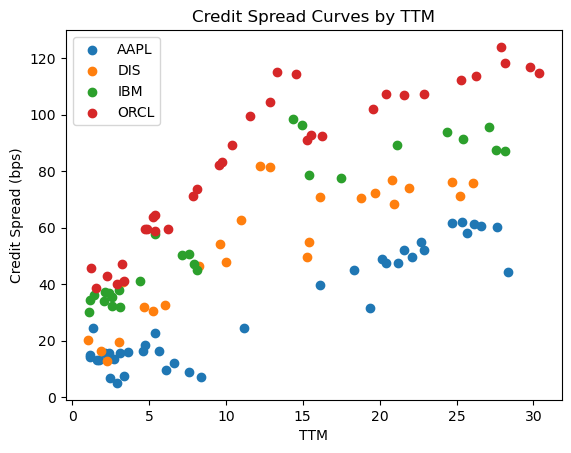

In [23]:
plt.figure()
for issuer in df_corp["ticker"].unique():
    d = df_corp[df_corp["ticker"]==issuer]
    plt.scatter(d["TTM"], d["credit_spread"], label=issuer)
plt.legend()
plt.title("Credit Spread Curves by TTM")
plt.xlabel("TTM")
plt.ylabel("Credit Spread (bps)")
plt.show()

## c. Add g-spreads

Add two new columns to the joint corporate bond dataframe:

| interp_tsy_yield | g_spread |
|----------|-------|

where 

*  `interp_tsy_yield` = interpolated treasury yield (using on-the-run treasuries only), matching the issue maturity
*  `g_spread` = (issue yield - interp_tsy_yield) * 100.

In [24]:
f = interp1d(merged_us_treasuries_on_the_run["TTM"], merged_us_treasuries_on_the_run["midYield"],
             kind="cubic", fill_value="extrapolate")

df_corp["interp_tsy_yield"] = f(df_corp["TTM"])
df_corp["g_spread"] = (df_corp["midYield"] - df_corp["interp_tsy_yield"])*100
df_corp.head()

,ticker,class,figi,isin,und_bench_isin,security,name,type,coupon,cpn_type,...,askPrice,accrued,bidYield,askYield,midPrice,midYield,und_bench_yield,credit_spread,interp_tsy_yield,g_spread
0,AAPL,Corp,BBG004HST0K7,US037833AL42,US912810UF39,AAPL 3.85 05/04/43,APPLE INC,GLOBAL,3.850,FIXED,...,85.148,0.4490,5.157,5.105,84.8670,5.1310,4.682,44.90,4.643904,48.709555
1,AAPL,Corp,BBG006F8VWJ7,US037833AT77,US912810UF39,AAPL 4.45 05/06/44,APPLE INC,GLOBAL,4.450,FIXED,...,93.617,0.4940,5.030,4.966,93.2430,4.9980,4.682,31.60,4.669730,32.826987
2,AAPL,Corp,BBG0081TNL50,US037833BA77,US912810UF39,AAPL 3.45 02/09/45,APPLE INC,GLOBAL,3.450,FIXED,...,78.915,1.2170,5.200,5.143,78.6120,5.1715,4.682,48.95,4.687146,48.435359
3,AAPL,Corp,BBG008N1BQC1,US037833BH21,US912810UF39,AAPL 4 3/8 05/13/45,APPLE INC,GLOBAL,4.375,FIXED,...,90.517,0.4010,5.184,5.130,90.1970,5.1570,4.682,47.50,4.692474,46.452637
4,AAPL,Corp,BBG00C7QB7Q2,US037833BY53,US91282CLY56,AAPL 3 1/4 02/23/26,APPLE INC,GLOBAL,3.250,FIXED,...,98.771,1.0205,4.455,4.321,98.6945,4.3880,4.247,14.10,4.288997,9.900258


## d. G-spread curve plots

Plot a graph/scatter plot of g-spread curves by TTM (one line per issuer).


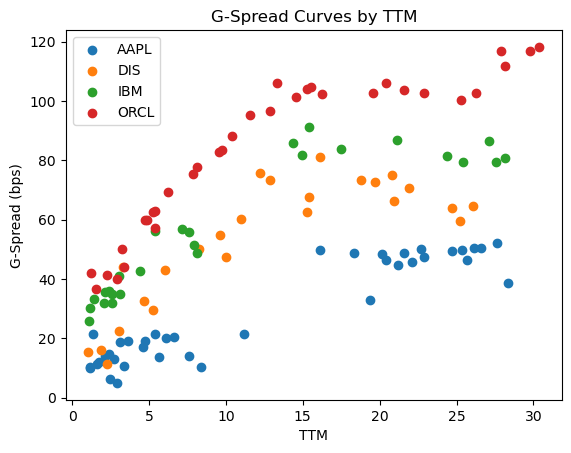

In [25]:
plt.figure()
for issuer in df_corp["ticker"].unique():
    d = df_corp[df_corp["ticker"]==issuer]
    plt.scatter(d["TTM"], d["g_spread"], label=issuer)
plt.legend()
plt.title("G-Spread Curves by TTM")
plt.xlabel("TTM")
plt.ylabel("G-Spread (bps)")
plt.show()